**車の走行距離を計測してみよう！**

燃料1ガロン当たり、どのくらい車が走行できるかを予測するAIを作成してみましょう。

今回使用するデータ「auto_mgp.csv」は、以下のような内容です。

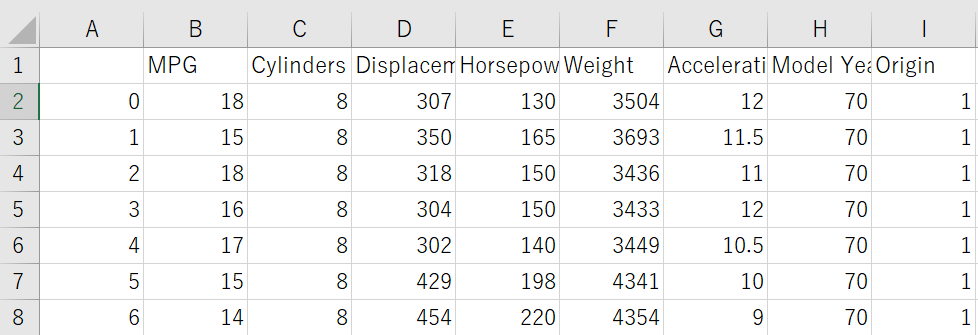

正解データ：MPG

特徴量データ：Cylinders、Displacement、Horsepower、Weight、Acceleration、Model Year、Origin

※A列のデータはただの行番号の為、今回は使用しません

※それぞれの列の役割は下記を参照してください。

　MPG		燃料1ガロンあたりにつき何マイル走るかの燃費

　Cylinders	エンジンのシリンダー数

　Displacement	排気量

　Horsepower	馬力

　Weight		車重

　Acceleration	加速度

　Model Year	発表年

　Origin		(origin == 1)はアメ車、(origin == 2)は欧州車、(origin == 3)は日本車


準備作業１．ドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


準備作業２．ディレクトリの作成

In [2]:
mkdir data

準備作業３．ディレクトリへの移動

In [3]:
cd data

/content/data


準備作業４．今回使用するauto_mgp.csvをアップロード
※コードなし

準備作業５．今回使用するライブラリのインストール



In [4]:
# pandsライブラリの使用
import pandas as pd

# モデルデータのインポート
# 今回は予測分析を行っていく為、モデルは重回帰分析で行っていきます。
from sklearn.linear_model import LinearRegression

# 訓練データ、検証データ、テストデータを分割する為に使用(後述)
from sklearn.model_selection import train_test_split

・CSVファイルの読み込みと表示

※データが正しく読み込まれているかを確認する為、必ずデータの表示を行いましょう。

In [5]:
# csvファイルの読み込み
df = pd.read_csv('auto_mgp.csv')

# データの確認(先頭5行・末尾5行)
print('-----先頭5行-----')
print(df.head(5))
print('-----末尾5行-----')
print(df.tail(5))

-----先頭5行-----
   Unnamed: 0   MPG  Cylinders  Displacement  Horsepower  Weight  \
0           0  18.0          8         307.0       130.0    3504   
1           1  15.0          8         350.0       165.0    3693   
2           2  18.0          8         318.0       150.0    3436   
3           3  16.0          8         304.0       150.0    3433   
4           4  17.0          8         302.0       140.0    3449   

   Acceleration  Model Year  Origin  
0          12.0          70       1  
1          11.5          70       1  
2          11.0          70       1  
3          12.0          70       1  
4          10.5          70       1  
-----末尾5行-----
     Unnamed: 0   MPG  Cylinders  Displacement  Horsepower  Weight  \
393         393  27.0          4         140.0        86.0    2790   
394         394  44.0          4          97.0        52.0    2130   
395         395  32.0          4         135.0        84.0    2295   
396         396  28.0          4         120.0       

【前処理】

機械学習を始めるための下準備として、前処理を行います。

データを学習させるために正しく整形しておくこのステップは、とても大切です。

前処理には、「ダミー変数化」、「欠損値の確認と処理」、「外れ値の確認と処理」があります。

ダミー変数化：質的データを学習に使えるように変換します。

欠損値の処理：値が入っていないセルを、計算できるように仮の値で埋めます。

外れ値の処理：イレギュラーな値が入っていた場合、学習結果に影響を及ぼす事があるため、学習に使用されないように削除します。

今回は、ダミー変数化後、【訓練データ、検証データ、テストデータの分割】を先に行ってから、欠損値・外れ値の確認と処理を行います。

こうしておく事で、テスト環境で欠損値や外れ値が入っているデータで確認が出来る為、本番環境での精度を保証する事が出来ます。

【質的データの確認】


・文字列のデータ

・0、1、2などの範囲の狭い整数

これらのデータをダミー変数化します。

ダミー変数化するポイントは、文字列かどうか、「数値として計算する意味があるかどうか」です。

今回のOrigin列は1～3の値しかないですし、内容もどこの国産かの値ですので、ダミー変数化してしまいます。

In [6]:
# Origin列にデータが何種類あるか調べる
df['Origin'].value_counts()

1    249
3     79
2     70
Name: Origin, dtype: int64

Origin列はデータが3種類しかなく、意味も「数値として計算する意味」はない為、ダミー変数化します。

In [7]:
# ダミー変数化
origin = pd.get_dummies(df['Origin'], drop_first = True)

# dfとダミー変数化した列を連結し、元のOriginを削除
df2 = pd.concat([df, origin], axis = 1)
df2 = df2.drop(['Origin'], axis = 1)
df2.head(2)

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,2,3
0,0,18.0,8,307.0,130.0,3504,12.0,70,0,0
1,1,15.0,8,350.0,165.0,3693,11.5,70,0,0


データの分割：

　訓練データ、検証データ、テストデータを分割します。

In [8]:
# 訓練データ&検証データとテストデータに分割する
train_val, test = train_test_split(df2, test_size = 0.2, random_state = 0)

欠損値の確認

In [9]:
# 欠損値の確認
train_val.isnull().any(axis = 0)

Unnamed: 0      False
MPG             False
Cylinders       False
Displacement    False
Horsepower       True
Weight          False
Acceleration    False
Model Year      False
2               False
3               False
dtype: bool

Horsepower列に欠損値がある事が分かりました。

※Horsepower列は「馬力」

In [10]:
# 欠損値が具体的に何個あるか確認してみましょう。
train_val.isnull().sum()

Unnamed: 0      0
MPG             0
Cylinders       0
Displacement    0
Horsepower      5
Weight          0
Acceleration    0
Model Year      0
2               0
3               0
dtype: int64

欠損値の処理：

　欠損値の処理の仕方で、このAIモデルの精度にも影響が出てきます。

　今回は平均値で補完しておきましょう。

In [11]:
# 欠損値を平均値で穴埋め
train_val2 = train_val.fillna(train_val.mean())
# 穴埋めできたか確認
train_val2.isnull().any(axis = 0)

Unnamed: 0      False
MPG             False
Cylinders       False
Displacement    False
Horsepower      False
Weight          False
Acceleration    False
Model Year      False
2               False
3               False
dtype: bool

外れ値の確認：

　外れ値の確認は、散布図を作成すると確認がしやすくなります。

　コラボラトリー上にグラフ描画をし、それを日本語化する為に以下のコードを実行しましょう。

In [12]:
# グラフの日本語化を行う為にインストール
!pip install japanize-matplotlib

# グラフを行内表示に設定
%matplotlib inline

     |████████████████████████████████| 4.1 MB 3.1 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=7ec30992a08f67354b5778bd9ae0c60a7303dd39552f44141c194f5a475ea79f
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


外れ値の確認は「散布図」を使うと分かり易くなります。

各特徴量と正解データの相関関係を表示しましょう。

"\n# 以下のように、forを使用して指定する事も可能です。\n# 今回は元データが1列目は使用しない、2列目が正解データなので、forのループ回数に注目してください\n\n# データフレームから列名のリストを取得\ncolname = train_val2.columns\n# 正解データの列名を取得する\nans = colname[1]\n# colnameリストのindex:2～最後までを取得(0と1はそれぞれ行番号及び正解データの為切り取る)\nval = colname[2:]\n# forループで全ての要素を散布図で出力\nfor name in val:\n  train_val2.plot(kind = 'scatter', x = name, y = ans)\n"

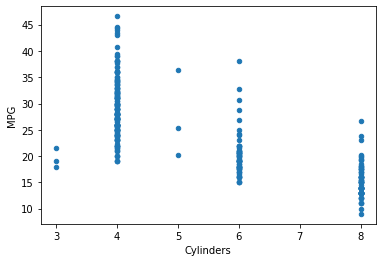

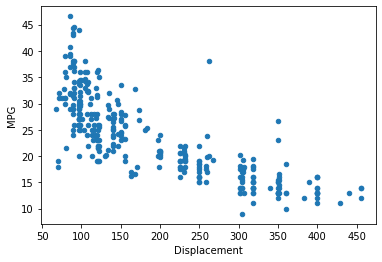

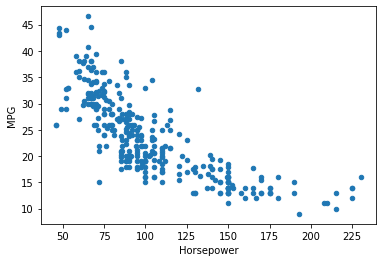

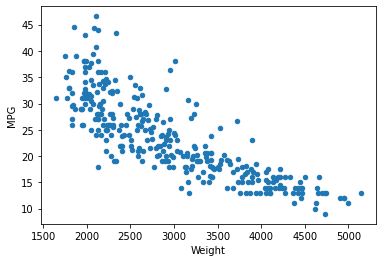

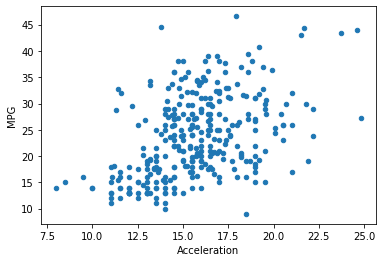

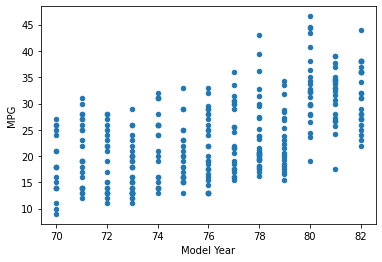

In [13]:
# plotメソッドのkind引数に「scatter」を指定すると散布図になります。
# x引数に特徴量、y引数に正解データの列名をそれぞれ指定します。
train_val2.plot(kind = 'scatter', x = 'Cylinders', y = 'MPG')
train_val2.plot(kind = 'scatter', x = 'Displacement', y = 'MPG')
train_val2.plot(kind = 'scatter', x = 'Horsepower', y = 'MPG')
train_val2.plot(kind = 'scatter', x = 'Weight', y = 'MPG')
train_val2.plot(kind = 'scatter', x = 'Acceleration', y = 'MPG')
train_val2.plot(kind = 'scatter', x = 'Model Year', y = 'MPG')


"""
# 以下のように、forを使用して指定する事も可能です。
# 今回は元データが1列目は使用しない、2列目が正解データなので、forのループ回数に注目してください

# データフレームから列名のリストを取得
colname = train_val2.columns
# 正解データの列名を取得する
ans = colname[1]
# colnameリストのindex:2～最後までを取得(0と1はそれぞれ行番号及び正解データの為切り取る)
val = colname[2:]
# forループで全ての要素を散布図で出力
for name in val:
  train_val2.plot(kind = 'scatter', x = name, y = ans)
"""

相関関係を見て、正解データのMPGと関連してそうな列をピックアップします。

全体のデータがバラバラな列は正解データとあまり関連がないので、今回は以下の列をピックアップします。

Displacement

Horsepower

Weight

Model Year

これら4つの列がMPGと関係がありそうです。

この中から、外れ値がありそうな列だけ外れ値処理を行っておきましょう。

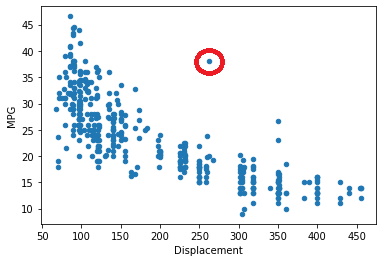

外れ値の処理

外れ値の処理を行う場合は、対象となる行を削除します。

対象となる行番号を調べて、削除の手順で処理を行います。

In [14]:
# 外れ値が存在するインデックスを調べる
out_line1 = train_val2[(train_val2['Displacement'] > 250) & (train_val2['MPG'] > 35)].index

# インデックス番号を出力して確認
print(out_line1)

Int64Index([387], dtype='int64')


In [15]:
# 外れ値の行を削除する
train_val3 = train_val2.drop([387], axis = 0)

In [16]:
# 相関関係で、今回対象とする列を取り出す
col = ['MPG','Displacement', 'Horsepower', 'Weight', 'Model Year']

train_val4 = train_val3[col]
train_val4.head(3)

,MPG,Displacement,Horsepower,Weight,Model Year
64,15.0,318.0,150.0,4135,72
55,27.0,97.0,60.0,1834,71
317,34.3,97.0,78.0,2188,80


特徴量は正解データの相関係数が大きいほど、特徴量が予測に与える影響が大きく、モデルの予測性能が高くなる可能性がある。

その為、列同士の相関係数を調べる事で、より予測精度を上げる事が出来るので、相関係数を使って特徴量の絞り込みを行います

In [17]:
# 列同士の相関係数を調べる
train_val4.corr()

,MPG,Displacement,Horsepower,Weight,Model Year
MPG,1.000000,-0.807965,-0.788586,-0.828652,0.569262
Displacement,-0.807965,1.000000,0.894243,0.933676,-0.353566
Horsepower,-0.788586,0.894243,1.000000,0.863366,-0.407420
Weight,-0.828652,0.933676,0.863366,1.000000,-0.292003
Model Year,0.569262,-0.353566,-0.407420,-0.292003,1.000000


正の相関関係が強いと1に近づき、負の相関関係が強いと-1に近づきます。

正解データ(MPG)とそれぞれの列との相関関係を数値で確認してみましょう。

In [18]:
# 各列とPRICE列との相関係数を見る
train_cor = train_val4.corr()['MPG']
train_cor

MPG             1.000000
Displacement   -0.807965
Horsepower     -0.788586
Weight         -0.828652
Model Year      0.569262
Name: MPG, dtype: float64

正負関係なく、相関関係が高いかどうかを確認する為には、abs関数で絶対値に変換すると見やすくなります。

In [19]:
# abs関数とmapメソッドを組み合わせて、絶対値に変換
abs_cor = train_cor.map(abs)
abs_cor

MPG             1.000000
Displacement    0.807965
Horsepower      0.788586
Weight          0.828652
Model Year      0.569262
Name: MPG, dtype: float64

更に確認しやすくする為、降順に並び替えてみましょう。

In [20]:
# 降順に並び替えるascending引数がTrue = 昇順、False = 降順となります。
abs_cor.sort_values(ascending = False)

MPG             1.000000
Weight          0.828652
Displacement    0.807965
Horsepower      0.788586
Model Year      0.569262
Name: MPG, dtype: float64

Model Yearが低めな事が分かりました。

今回はWeight、Displacement、Horsepowerを使用してモデルを作成していきます。

In [21]:
# 使用する特徴量の列を抽出する
col = ['Weight', 'Displacement', 'Horsepower']
x = train_val4[col]
t = train_val4[['MPG']]

#訓練データと検証データの分割
x_train, x_val, y_train, y_val = train_test_split(x, t, test_size = 0.2, random_state = 0)


【標準化】
　特徴量の平均値とばらつきを統一させる処理

　データは項目や値によって数値の重みが変わってきます。

　元のデータ集合がどのような分布でも、標準化後のデータ集合は「平均値が0、標準偏差が1」の分布となります。

　こうする事で、適切な比較と分析が可能になり、機械学習手法によっては予測性能が向上します。



In [22]:
# scikit-learnのpreprocessingモジュールを使用して、データを標準化させる
from sklearn.preprocessing import StandardScaler

sc_model_x = StandardScaler()
# 各列の平均値や標準偏差を調べて、sc_model_xに格納している
sc_model_x.fit(x_train)

# 各列のデータを標準化してsc_xに代入
sc_x = sc_model_x.transform(x_train)
sc_x

array([[-9.76090308e-01, -9.31028993e-01, -9.83645855e-01],
       [-1.12530316e+00, -1.04979137e+00, -1.03750162e+00],
       [-2.89711198e-01, -1.09927570e+00,  1.74253032e-01],
       [-8.86562598e-01, -6.83607368e-01, -4.72016114e-01],
       [-9.64153280e-01, -7.92472883e-01, -6.33583400e-01],
       [-1.06084321e+00, -1.10917256e+00, -9.02862211e-01],
       [-8.82981490e-01, -1.00030705e+00, -8.75934330e-01],
       [ 2.33130629e-01,  5.83191351e-01, -8.49006449e-01],
       [ 1.12721403e+00,  3.95150916e-01,  1.74253032e-01],
       [-9.99964364e-01, -9.21132128e-01, -9.02862211e-01],
       [-4.38924048e-01, -1.78867254e-01,  3.08892438e-01],
       [ 2.46261360e-01,  1.09782833e+00,  6.85882773e-01],
       [-1.20886235e+00, -1.10917256e+00, -9.83645855e-01],
       [ 1.78255686e+00,  1.57287785e+00,  1.52064709e+00],
       [-1.39388629e+00, -9.90410183e-01, -1.36063619e+00],
       [-1.32823263e+00, -9.90410183e-01, -9.83645855e-01],
       [-7.91066374e-01, -7.13297963e-01

【標準化されているか確認】

In [23]:
# 平均値0を確認する
# arry型だと見づらいのでデータフレームに変換
tmp_df = pd.DataFrame(sc_x, columns = x_train.columns)

# 平均値の計算(厳密な0にはならないが、限りなく0に近い値(e-16やe-17)であればOK)
tmp_df.mean()

Weight          1.799176e-17
Displacement   -1.158494e-16
Horsepower      2.031752e-16
dtype: float64

In [24]:
# 標準偏差1を確認する
tmp_df.std()

Weight          1.001982
Displacement    1.001982
Horsepower      1.001982
dtype: float64

【正解データの標準化】

　一般的には特徴量と併せて、正解データも標準化します。

In [25]:
# 正解データの標準化
sc_model_y = StandardScaler()
sc_model_y.fit(y_train)

sc_y = sc_model_y.transform(y_train)
# 結果の出力は割愛

モデルの評価とチューニング



In [26]:
# 標準化したデータで学習を行う
model = LinearRegression()
model.fit(sc_x, sc_y)


# 標準化データを使用した場合の注意点
model.score(x_val, y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


-34905.89196917619

決定係数がマイナスに振り切っています。

これは、標準化した時は、検証データも標準化する必要がある為です。

In [27]:
# 検証データを標準化する
sc_x_val = sc_model_x.transform(x_val)
sc_y_val = sc_model_y.transform(y_val)

# 標準化した検証データで決定係数を計算
model.score(sc_x_val, sc_y_val)

0.684668987490802

正しく決定係数が出力されました。

チューニングの目標と準備

この後色々なパターンでテストをしていくので、チューニングを楽にするために専用の関数を用意しましょう。

In [28]:
# learn関数の定義
def learn(x, t):
  x_train, x_val, y_train, y_val = train_test_split(x, t, test_size = 0.2, random_state = 0)
  # 訓練データを標準化
  sc_model_x = StandardScaler()
  sc_model_y = StandardScaler()
  sc_model_x.fit(x_train)
  sc_x_train = sc_model_x.transform(x_train)
  sc_model_y.fit(y_train)
  sc_y_train = sc_model_y.transform(y_train)
  # 学習
  model = LinearRegression()
  model.fit(sc_x_train, sc_y_train)

  # 検証データを標準化
  sc_x_val = sc_model_x.transform(x_val)
  sc_y_val = sc_model_y.transform(y_val)
  # 訓練データと検証データの決定係数検索
  train_score = model.score(sc_x_train, sc_y_train)
  val_score = model.score(sc_x_val, sc_y_val)

  return train_score, val_score

learn関数のテスト

In [29]:
x = train_val3.loc[ :,['Weight', 'Displacement', 'Horsepower']]
t = train_val3[['MPG']]

s1, s2 = learn(x, t)
print(s1, s2)

0.7144606277778914 0.684668987490802


特徴量エンジニアリング

　準備されたデータをもとに新しい列を作成して、特徴量に加える事を、特徴量エンジニアリングといいます。

　特徴量エンジニアリングを行う事で、スコアがどう変化していくのかを確認していきましょう。

多項式特徴量

　元のデータの列に対して2乗した値の列や、3乗した値の列を生成して、特徴量に加える方法。

In [30]:
# 関係係数が最も高いWeight列を2乗して変化を確認する

# 新規列Weight2にWeightの2乗を代入
x['Weight2'] = x['Weight'] ** 2
x.head(2)


,Weight,Displacement,Horsepower,Weight2
64,4135,318.0,150.0,17098225
55,1834,97.0,60.0,3363556


再学習をして決定係数を確認します。

In [31]:
s1, s2 = learn(x, t)
print(s1, s2)

0.7379970874651185 0.7272442049922678


決定係数が上がりました。
更に、Displacement列とHorsepower列も2乗してみましょう。

In [32]:
# Displacement列の2乗を追加
x['Displacement2'] = x['Displacement'] ** 2
s1, s2 = learn(x, t)
print(s1, s2)

# Horsepower列の2乗を追加
x['Horsepower2'] = x['Horsepower'] ** 2
s1, s2 = learn(x, t)
print(s1, s2)

0.7622085359799569 0.709289479971016
0.7656937654268144 0.7271447642740612


あまり変化がありません。
こういう時は、3乗や4乗も試してみましょう。

In [33]:
# Displacement列の3乗を追加
x['Displacement3'] = x['Displacement'] ** 3
s1, s2 = learn(x, t)
print(s1, s2)

# Horsepower列の4乗を追加
x['Horsepower4'] = x['Horsepower'] ** 4
s1, s2 = learn(x, t)
print(s1, s2)

0.7664986991127657 0.7256425918795737
0.7680924223506955 0.7418654240012732


大きな変化は見られませんが、少しだけ上がりました。

交互作用特徴量

　特徴量同士を組み合わせて新しい特徴量を作る手法

In [34]:
# データ比較の為、一度xを初期化
x = train_val3.loc[ :,['Weight', 'Displacement', 'Horsepower']]

# 交互作用特徴量を追加する
x['Weight * Displacement'] = x['Weight'] * x['Displacement']
x.head(2)

,Weight,Displacement,Horsepower,Weight * Displacement
64,4135,318.0,150.0,1314930.0
55,1834,97.0,60.0,177898.0


In [35]:
s1, s2 = learn(x, t)
print(s1, s2)

0.7531069697175834 0.715975419334083


他の列も組み合わせてみます。

In [36]:
x['Weight * Horsepower'] = x['Weight'] * x['Horsepower']

s1, s2 = learn(x, t)
print(s1, s2)

0.7535224093252028 0.7255285448622442


In [37]:
x['Displacement * Horsepower'] = x['Displacement'] * x['Horsepower']

s1, s2 = learn(x, t)
print(s1, s2)

0.7687685351697306 0.7231047997512061


少しずつですが、上がっている事が分かります。

多項式特徴量と交互作用特徴量を組み合わせる事も可能です。
この組み合わせを使って、0.8を目指してみましょう。

In [38]:
# データ比較の為、一度xを初期化
x = train_val3.loc[ :,['Weight', 'Displacement', 'Horsepower']]

# 新規列Weight2にWeightの2乗を代入
x['Weight2'] = x['Weight'] ** 2
x['Displacement2'] = x['Displacement'] ** 2

# 交互作用特徴量を追加する
x['Weight2 * Displacement2'] = x['Weight2'] * x['Displacement2']

s1, s2 = learn(x, t)
print(s1, s2)

0.7622421278680784 0.7079742164579516


このように、複数のパターンを試していって、より高い決定係数を探っていきましょう。

今回は最も高い多項式特徴量のパターンでテストデータでの評価を行ってみましょう。

In [39]:
# データ比較の為、一度xを初期化
x = train_val3.loc[ :,['Weight', 'Displacement', 'Horsepower']]


# 新規列Weight2にWeightの2乗を代入
x['Weight2'] = x['Weight'] ** 2
# Displacement列の2乗を追加
x['Displacement2'] = x['Displacement'] ** 2
# Horsepower列の2乗を追加
x['Horsepower2'] = x['Horsepower'] ** 2
# Displacement列の3乗を追加
x['Displacement3'] = x['Displacement'] ** 3
# Horsepower列の4乗を追加
x['Horsepower4'] = x['Horsepower'] ** 4

s1, s2 = learn(x, t)
print(s1, s2)

0.7680924223506955 0.7418654240012732


最適な前処理やモデルチューニングが判明したら、モデルに再学習させます。

この場合、再学習するデータは訓練データと検証データを合わせた前データ(テストデータを除く)です。
再学習の前に、データの標準化も忘れないように注意しましょう。

In [40]:
# 訓練データと検証データを合わせて再学習させるので、再度標準化する
sc_model_x2 = StandardScaler()
sc_model_x2.fit(x)
sc_x = sc_model_x2.transform(x)

sc_model_y2 = StandardScaler()
sc_model_y2.fit(t)
sc_y = sc_model_y2.transform(t)
model = LinearRegression()
model.fit(sc_x, sc_y)

LinearRegression()

テストデータも同様に前処理を行います。

但し、未知のデータでの予測性能を評価するためには、外れ値があっても恣意的に削除してはいけません。

前処理において外れ値の処理は行わない点に注意してください。

In [41]:
test2 = test.fillna(train_val.mean()) # 欠損値を平均値で補完
x_test = test2.loc[ :, ['Weight',	'Displacement',	'Horsepower']]
y_test = test2[['MPG']]

x_test['Weight2'] = x_test['Weight'] ** 2
x_test['Displacement2'] = x_test['Displacement'] ** 2
x_test['Horsepower2'] = x_test['Horsepower'] ** 2
x_test['Displacement3'] = x_test['Displacement'] ** 3
x_test['Horsepower4'] = x_test['Horsepower'] ** 4

sc_x_test = sc_model_x2.transform(x_test)
sc_y_test = sc_model_y2.transform(y_test)

決定係数の計算をしてみましょう

In [42]:
model.score(sc_x_test, sc_y_test)

0.7153619836616814

最後にモデルの保存をして完了です

In [43]:
import pickle
with open('auto_mpg.pkl', 'wb') as f:
  pickle.dump(model, f)

【Tips】
　他のモデルを使った時に、今回の決定係数【0.71】がどう変化するか見てみましょう。

　ここまでの手順と同じ為、細かい解説は省略していきます。

【リッジ回帰】

　係数をできるだけ小さくしつつ、予測と実際の誤差を少なくするモデル。

　「係数の2乗の合計」を使用する。

In [44]:
# 必要な物をインポート
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.preprocessing import StandardScaler

In [48]:
# データの読み込み
df = pd.read_csv('auto_mgp.csv')
# 欠損値補完
df = df.fillna(df.mean())
# 外れ値の駆除
df = df.drop([387], axis = 0)

# 正解データ抜き出し
t = df[['MPG']]
# 特徴量抜き出し
x = df.loc[:, ['Weight', 'Displacement', 'Horsepower']]

# 標準化
sc = StandardScaler()
sc_x = sc.fit_transform(x)
sc2 = StandardScaler()
sc_t = sc2.fit_transform(t)

In [49]:
# 累乗列と交互作用特徴量を一括追加する
from sklearn.preprocessing import PolynomialFeatures

# degree引数で乗数を指定
pf = PolynomialFeatures(degree = 2, include_bias = False)
# 2乗列と交互作用特徴量の追加
pf_x = pf.fit_transform(sc_x)
# 行数と列数
pf_x.shape

(397, 9)

In [50]:
# 列名を確認する処理
pf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']

In [53]:
# データの分割
x_train, x_test, y_train, y_test = train_test_split(pf_x, sc_t, test_size = 0.3, random_state = 0)

In [56]:
# リッジ回帰を使用して測定
from sklearn.linear_model import Ridge

# モデルの作成
ridgeModel = Ridge(alpha = 10)
ridgeModel.fit(x_train, y_train) # 学習
print(ridgeModel.score(x_train, y_train))
print(ridgeModel.score(x_test, y_test))

0.758810767001904
0.7635123998791967


【ラッソ回帰】

　係数が小さくなるように回帰式を作成する手法。

　「係数の絶対値の合計」を使用する。

In [58]:
# ラッソ回帰の使用
from sklearn.linear_model import Lasso

# ラッソ回帰のモデル作成
model = Lasso(alpha = 0.1)
model.fit(x_train, y_train)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.7090152163597226
0.742975175904216


　これらのモデルは、用途や元データによって使い分け、最も予測値の高い前処理・モデルを探していけるように練習しておきましょう。